In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Visualization function with a custom colormap
def visualize_grid(grid, my_alpha, title=''):
    # Define a custom colormap from light blue to white
    colors = [(0.678, 0.847, 0.902), (1, 1, 1)]  # Light blue to white (RGB values)
    cmap = LinearSegmentedColormap.from_list('custom_blue_white', colors, N=256)

    # Hill equation parameters
    n = my_alpha  # Hill coefficient
    K_d = 0.25  # Dissociation constant, you can adjust this value as needed

    # Apply the Hill equation to the grid values
    hill_grid = (np.clip((grid**n) / (K_d**n + grid**n), 0, 1)) * 255

    # Plot the grid with the custom colormap
    plt.imshow(hill_grid, cmap=cmap)

    # Size of the plot
    plt.gcf().set_size_inches(15, 5)

    plt.colorbar(label='Noise Intensity')
    plt.title(title)
    plt.grid(False)  # Optional: hide gridlines for a cleaner look
    plt.xticks([])   # Optional: hide x-axis ticks
    plt.yticks([])   # Optional: hide y-axis ticks
    plt.show()

# Compute radii function
def compute_radii(points, exponent=1.2, min_circle=3, max_circle=10):
    u = np.random.uniform(0, 1, size=len(points))  # uniform random values
    radii = min_circle * (1 - u) ** (-1 / (exponent))
    return np.minimum(radii, max_circle)  # Cap radii at max_circle

# Generate the noise grid with radii
def circle_to_point_with_radii(grid, radii):
    size_x, size_y = grid.shape
    noise_grid = np.zeros((size_x, size_y))
    points = np.argwhere(grid == 1)

    if len(points) == 0:
        return noise_grid

    x_indices, y_indices = np.indices((size_x, size_y))
    points_x = points[:, 0][:, np.newaxis, np.newaxis]
    points_y = points[:, 1][:, np.newaxis, np.newaxis]
    radii_squared = radii[:, np.newaxis, np.newaxis] ** 2
    dist_squared = (x_indices - points_x) ** 2 + (y_indices - points_y) ** 2
    contribution = (dist_squared < radii_squared).astype(float)
    noise_grid += np.sum(contribution, axis=0)

    noise_grid[noise_grid == 1] = 0
    noise_grid[noise_grid == 2] = 0

    min_val = np.min(noise_grid)
    max_val = np.max(noise_grid)
    noise_grid = (noise_grid - min_val) / (max_val - min_val)
    return noise_grid




In [61]:
import numpy as np
from numba import jit

@jit(nopython=True)  # Just-In-Time compilation for speed
def circle_to_point_with_radii(grid, radii):
    size_x, size_y = grid.shape
    noise_grid = np.zeros((size_x, size_y))
    points = np.argwhere(grid == 1)

    if len(points) == 0:
        return noise_grid

    num_points = len(points)

    # Create indices for grid
    x_indices = np.arange(size_x)[:, np.newaxis]  # shape (size_x, 1)
    y_indices = np.arange(size_y)[np.newaxis, :]   # shape (1, size_y)

    # Iterate over each point
    for i in range(num_points):
        px, py = points[i]
        radius_squared = radii[i] ** 2
        
        # Define the bounds for the square region to check
        x_min = max(px - radii[i], 0)
        x_max = min(px + radii[i] + 1, size_x)
        y_min = max(py - radii[i], 0)
        y_max = min(py + radii[i] + 1, size_y)

        # Calculate distances in the bounding box
        for x in range(x_min, x_max):
            for y in range(y_min, y_max):
                dist_squared = (x - px) ** 2 + (y - py) ** 2
                if dist_squared < radius_squared:
                    noise_grid[x, y] += 1

    # Normalize the grid
    min_val = np.min(noise_grid)
    max_val = np.max(noise_grid)

    if min_val != max_val:  # Prevent division by zero
        noise_grid = (noise_grid - min_val) / (max_val - min_val)

    return noise_grid


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance

# generate a random point
def generate_points(grid, size_x, size_y, num_points, min_distance_btw_points, max_distance_btw_points):

    # generate first random point
    x = random.randint(0, size_x-1)
    y = random.randint(0, size_y-1)
    grid[x, y] = 1

    # generate the rest of the points with a max distance from previous points
    for i in range(num_points-1):
        
        # generate a number between min_distance_btw_points and max_distance_btw_points
        distance_x = random.randint(min_distance_btw_points, max_distance_btw_points)

        # compute max_distance_y
        max_distance_y = np.sqrt(max_distance_btw_points**2 - distance_x**2)

        # ensure max_distance_y is at least min_distance_btw_points
        if max_distance_y < min_distance_btw_points:
            max_distance_y = min_distance_btw_points

        # generate a number between 0 and max_distance_y
        distance_y = random.randint(min_distance_btw_points, int(max_distance_y))

        # generate a random sign
        sign_x = random.choice([-1, 1])
        sign_y = random.choice([-1, 1])

        # generate the new point
        new_x = x + sign_x * distance_x
        new_y = y + sign_y * distance_y

        # if new points are out of the grid, use continues boundaries
        if new_x < 0:
            new_x = size_x + new_x
        if new_x >= size_x:
            new_x = new_x - size_x
        
        if new_y < 0:
            new_y = size_y + new_y
        if new_y >= size_y:
            new_y = new_y - size_y

        # add the new point to the grid
        grid[new_x, new_y] = 1

        # update x and y
        x = new_x
        y = new_y

    return grid

In [75]:

 # A single point at the center, adjust for your grid
grid = generate_points(np.zeros((150, 300)), 150, 300, 300, 1, 13)

# Compute radii for the first and last frame
radii_1 = compute_radii(np.argwhere(grid == 1))
radii_2 = compute_radii(np.argwhere(grid == 1))



In [76]:
import numpy as np

def interpolate_radii(radii_1, radii_2, steps):
    """
    Linearly interpolates between radii_1 and radii_2 over a given number of steps.
    
    Parameters:
    - radii_1: np.array, initial radii (shape: (n,))
    - radii_2: np.array, final radii (shape: (n,))
    - steps: int, number of steps to interpolate

    Returns:
    - interpolated_radii: list of np.array, radii at each step (length: steps)
    """
    radii_1 = np.array(radii_1)
    radii_2 = np.array(radii_2)
    
    # Ensure both radii arrays have the same shape
    assert radii_1.shape == radii_2.shape, "radii_1 and radii_2 must have the same shape"
    
    # Compute the difference between the two radii
    delta_radii = (radii_2 - radii_1) / (steps - 1)
    
    # Generate the interpolated radii for each step
    interpolated_radii = [radii_1 + i * delta_radii for i in range(steps)]
    
    return interpolated_radii


In [77]:
in_between_radii = np.array(interpolate_radii(radii_1, radii_2, 100))

In [78]:
in_between_radii.shape

(100, 292)

In [79]:
# Generate the first and last frame
grid_1 = circle_to_point_with_radii(grid, radii_1)
grid_2 = circle_to_point_with_radii(grid, radii_2)


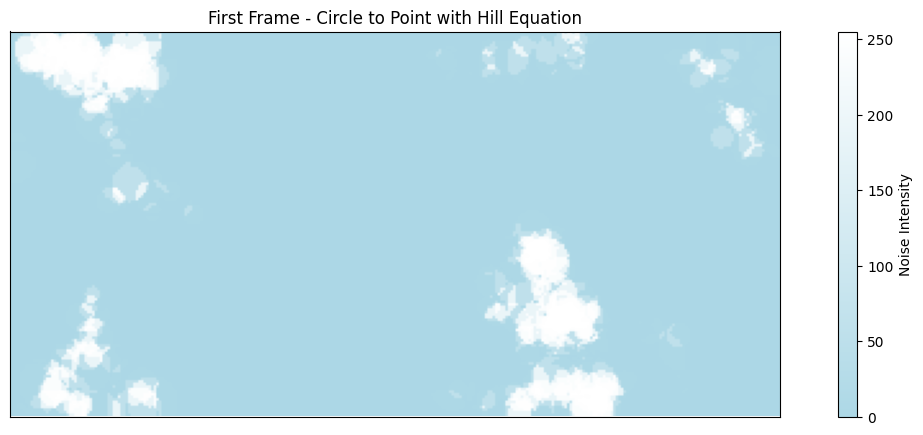

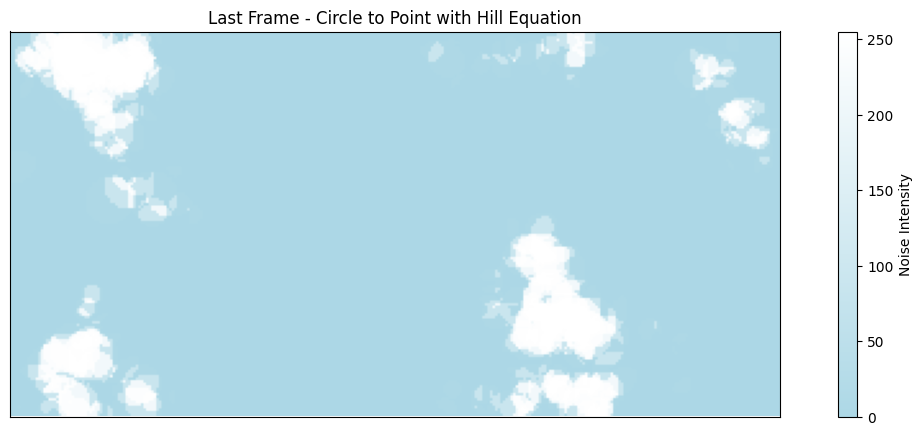

In [80]:
# Visualize the first and last frames
visualize_grid(grid_1, my_alpha=8, title='First Frame - Circle to Point with Hill Equation')
visualize_grid(grid_2, my_alpha=8, title='Last Frame - Circle to Point with Hill Equation')

In [81]:
import numpy as np

def generate_interpolated_grids(grid, radii_1, radii_2, steps, circle_to_point_with_radii):
    """
    Generates grids by interpolating radii between radii_1 and radii_2, applying them to the grid.
    
    Parameters:
    - grid: np.array, the initial grid (shape: (m, n))
    - radii_1: np.array, initial radii (shape: (n,))
    - radii_2: np.array, final radii (shape: (n,))
    - steps: int, number of steps for interpolation
    - circle_to_point_with_radii: function to generate the grid for each step using interpolated radii
    
    Returns:
    - grids_stack: np.array, stacked grids at each step (shape: (steps, m, n))
    """
    # Interpolate radii
    interpolated_radii = interpolate_radii(radii_1, radii_2, steps)
    
    # Stack all grids
    grids_stack = []
    
    for radii_n in interpolated_radii:
        # Generate the grid for the current radii and append to the list
        grid_n = circle_to_point_with_radii(grid.copy(), radii_n)
        grids_stack.append(grid_n)
    
    # Convert the list to a numpy array and stack all grids
    grids_stack = np.stack(grids_stack, axis=0)
    
    return grids_stack

# Example of usage:
# Assuming the functions generate_points, compute_radii, circle_to_point_with_radii, and interpolate_radii are defined
grid = generate_points(np.zeros((150, 300)), 100, 200, 300, 1, 13)
radii_1 = compute_radii(np.argwhere(grid == 1))
radii_2 = compute_radii(np.argwhere(grid == 1))

# Generate all grids over the interpolation steps
steps = 100  # Number of interpolation steps
grids_stack = generate_interpolated_grids(grid, radii_1, radii_2, steps, circle_to_point_with_radii)


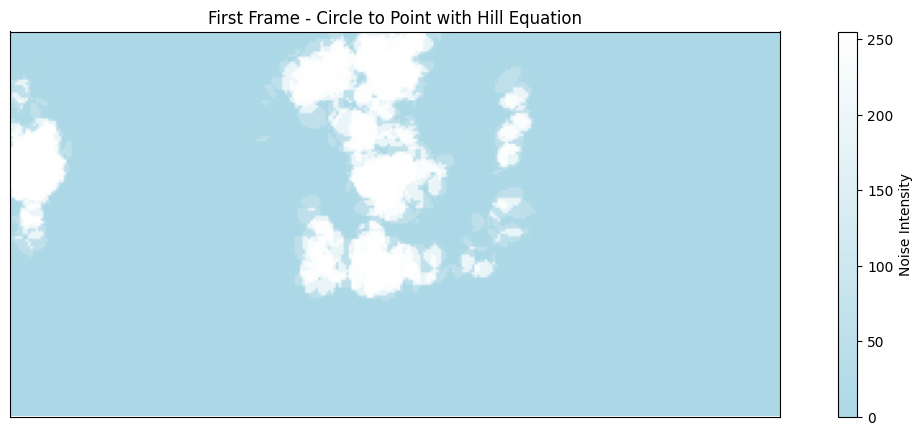

In [73]:
visualize_grid(grids_stack[9], my_alpha=8, title='First Frame - Circle to Point with Hill Equation')

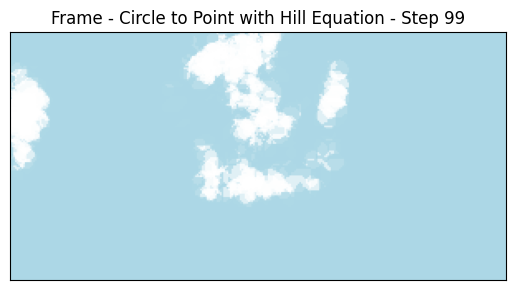

In [74]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_grids(grids_stack, T=80, grid_flag=False, intensity=0.3, my_alpha=8, title='Frame - Circle to Point with Hill Equation'):
    """
    Animates the grids from `grids_stack` using a modified `visualize_grid` approach.
    
    Parameters:
    - grids_stack: np.array, stacked grids to animate (shape: (steps, m, n))
    - T: int, number of frames (steps) for the animation
    - grid_flag: bool, whether to show grid lines
    - intensity: float, grid intensity for grid lines (only if `grid_flag` is True)
    - my_alpha: float, alpha value passed to `visualize_grid`
    - title: str, title to use in the visualization
    
    Returns:
    - HTML object displaying the animation.
    """
    fig, ax = plt.subplots()
    
    def init_animation():
        """Initialize animation with the first frame."""
        ax.clear()
        plot_frame(grids_stack[0], ax, my_alpha, title=f'{title} - Step 0')
        return []

    def update_animation(frame):
        """Update the frame for animation."""
        ax.clear()
        plot_frame(grids_stack[frame], ax, my_alpha, title=f'{title} - Step {frame}')
        return []

    def plot_frame(grid, ax, my_alpha, title):
        """Plots a single frame with the Hill equation and custom colormap."""
        colors = [(0.678, 0.847, 0.902), (1, 1, 1)]  # Light blue to white
        cmap = LinearSegmentedColormap.from_list('custom_blue_white', colors, N=256)
 
        # Hill equation
        n = my_alpha
        K_d = 0.25
        hill_grid = (np.clip((grid**n) / (K_d**n + grid**n), 0, 1)) * 255
        
        # Clear the axis, plot the updated grid, and adjust settings
        img = ax.imshow(hill_grid, cmap=cmap)
        ax.set_title(title)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

    # Create the animation using FuncAnimation
    animation = FuncAnimation(fig, update_animation, init_func=init_animation, frames=len(grids_stack), interval=T, blit=False)
    
    # Return the animation in HTML format
    return HTML(animation.to_jshtml())

# Example usage:
# Assuming you already have `grids_stack` generated
grids_stack = generate_interpolated_grids(grid, radii_1, radii_2, steps, circle_to_point_with_radii)
animate_grids(grids_stack)
